# Exercise 6: Application to Fluid Flow
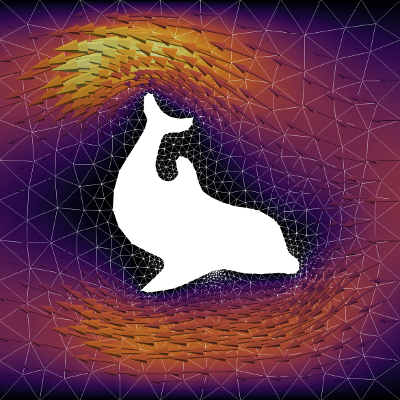

In this exercise, we will solve the Stokes equations with FEniCS:

\begin{alignat}{2}
-\nabla\cdot\sigma(u, p) &= f \quad && \text{in } \Omega \\
\nabla\cdot u &= 0 \quad && \text{in } \Omega \\
u &= u_{\mathrm{R}} \quad && \text{on } \Gamma_{\mathrm{R}} \\
\sigma\cdot n &= (0, 0) \quad && \text {on } \Gamma_{\mathrm{L}} \\
p &= p_{\mathrm{L}} \quad && \text {on } \Gamma_{\mathrm{L}} \\
u &= (0,0) \quad && \text{on } \Gamma_0 \\
\end{alignat}

where $\sigma(u) = 2\mu\varepsilon(u) - pI$ is the viscous stress tensor, $\varepsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^{\top})$ is the strain tensor (symmetric gradient) and $I$ is the identity matrix.

This is a model of linear (creeping) flow in the idealized case of infinitesimal (small) velocities.

We will use the following data:

* $\Omega$ defined by the mesh `dolfin_coarse.xml.gz`
* $f = (0,0)$
* $\Gamma_{\mathrm{L}} = \{(x,y,z) \in \partial\Omega \,\vert\, x = 0\}$ (the left boundary)
* $\Gamma_{\mathrm{R}} = \{(x,y,z) \in \partial\Omega \,\vert\, x = 1\}$ (the right boundary)
* $\Gamma_{0} = \partial\Omega \setminus (\Gamma_{\mathrm{L}} \cup \Gamma_{\mathrm{R}})$
* $p_{\mathrm{L}} = 0$ (outflow)
* $u_{\mathrm{R}} = (-\sin(\pi y), 0)$ (inflow)
* $\mu = 1$ (dynamic viscosity)

For hints and more reading on how to compute fluid flow in FEniCS, see the [section on the Navier-Stokes equations](https://fenicsproject.org/pub/tutorial/html/._ftut1009.html#ftut1:NS) in the [FEniCS Tutorial](https://fenicsproject.org/tutorial/).

## Importing FEniCS
The first thing we need to do is to import FEniCS.

In [1]:
try:
    from fenics import *
except ImportError:
    !conda install -c conda-forge fenics -y
    from fenics import *
try:
    from mshr import *
except ImportError:
    !conda install -c conda-forge mshr -y
    from mshr import *

## Initializing notebook plotting
When running in a Jupyter notebook, a special line is necessary to show FEniCS plots in the notebook.

In [2]:
%matplotlib inline

## Creating the mesh
To create the mesh, download the mesh from `https://fenicsproject.org/pub/data/meshes/` and load the mesh from file.


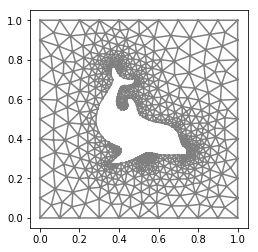

In [3]:
mesh = Mesh('dolfin_coarse.xml.gz')
plot(mesh)

## Defining the finite element function space
When we have created the mesh, we can define the finite element function space. Since we will be solving a system of equations, we need to create a *mixed* finite element which combines a vector finite element $V$ for the velocity and scalar finite element $Q$ for the pressure. Experiment with using both equal-order $P_1-P_1$ elements and $P_2-P_1$ Taylor hood elements.

In [4]:
P = VectorElement('P', triangle, 2)
Q = FiniteElement('P', triangle, 1)
W = FunctionSpace(mesh, P*Q)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


## Defining the boundary conditions
The boundary conditions can be defined by specifying all points on the boundary close to either of the two end points $x = 0$ and $x = 1$. Some care must be taken to define the no-slip boundary $\Gamma_0$ properly - experiment with different options to properly include all points! Use three `DirichletBC` objects to define the three boundary conditions.

Since we have a system of equations and want to specify boundary conditions for both components, we must use `W.sub(0)` and `W.sub(1)` to access the two components of the function space corresponding to `u` and `p` in the definition of the boundary conditions.

In [6]:
def left(x, on_boundary):
    return on_boundary and near(x[0], 0.0)

def right(x, on_boundary):
    return on_boundary and near(x[0], 1.0)

def bottom(x, on_boundary):
    return on_boundary and near(x[1], 0.0)

def top(x, on_boundary):
    return on_boundary and near(x[1], 1.0)

def dolphin(x, on_boundary):
    return on_boundary and not any(b(x, on_boundary) for b in [left, right, bottom, top])

def noslip(x, on_boundary):
    return on_boundary and any(b(x, on_boundary) for b in [bottom, top, dolphin])

p_L = Constant(0)
u_R = Expression(('-sin(pi*x[1])', '0.0'), degree=2)

bc_L = DirichletBC(W.sub(1), p_L, left)
bc_R = DirichletBC(W.sub(0), u_R, right)
bc_0 = DirichletBC(W.sub(0), Constant((0,0)), noslip)
bcs = [bc_L, bc_R, bc_0]

## Defining the variational problem
The finite element variational problem for the Stokes problem reads: Find $(u, p) \in W$ such that
$$
\int_{\Omega} \sigma(u) : \varepsilon(v) \,\mathrm{d}x
+
\int_{\Omega} \nabla \cdot u \, q \,\mathrm{d}x
=
\int_{\Omega} f \cdot v \,\mathrm{d}x
$$
for all $(v, q) \in W$. Note that the boundary traction terms vanish as a result of setting Dirichlet boundary conditions on $\Gamma_{R}$ and $\Gamma_{0}$ (and thus $v = 0$), and by having $\sigma\cdot n = 0$ on the outflow boundary $\Gamma_{L}$.

This can be expressed in FEniCS by defining the *bilinear form* $a$ and the *linear form* $L$:

\begin{align}
  a(u, v) &= \int_{\Omega} \sigma(u) : \varepsilon(v) \,\mathrm{d}x, \\
  L(v) &= \int_{\Omega} f \cdot v \,\mathrm{d}x.
\end{align}

where $\sigma(u) = 2\mu\varepsilon(u) - pI$ and $\varepsilon(u) = \frac{1}{2}(\nabla u + (\nabla u)^{\top})$. Note that both $\sigma$ and $\varepsilon$ may be conveniently expressed as Python functions using the `def` keyword.

In [8]:
mu = Constant(1)
f = Constant((0,0))
d = 2

def epsilon(u):
    return sym(grad(u))

def sigma(u, p):
    return 2*mu*epsilon(u) - p*Identity(d)

u,p = TrialFunctions(W)
v,q = TestFunctions(W)
a = inner(sigma(u,p), epsilon(v))*dx + div(u)*q*dx
L = dot(f,v)*dx

## Solving the variational problem
The variational problem can now be solved by calling the FEniCS `solve` command. Use the `plot` command to visualize the solution. Extract the components of the mixed function $w = (u, p) \in W$ by using the command `w.split()`.

In [9]:
w = Function(W)
solve(a == L, w, bcs)
u, p = w.split()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


## Plotting the velocity
The velocity field may look reasonable even with an equal-order approximation...

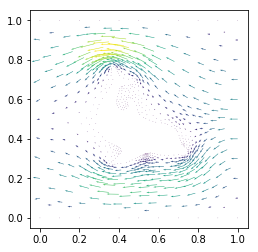

In [10]:
plot(u)

## Plotting the pressure
... but watch out for the pressure when $P_1-P_1$ elements are used. Change to a $P_2-P_1$ approximation and observe the difference.

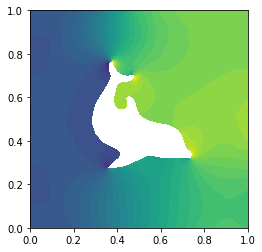

In [11]:
plot(p)

## Postprocessing
To postprocess the solution using an external postprocessor, for example Paraview, save the solution to VTK format (file suffix `.pvd`).

In [12]:
File('exercise6/velocity.pvd') << u
File('exercise6/pressure.pvd') << p